In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time as time_lib

import multiprocessing

from scripts.dynamics import vecField
from scripts.plotting import plot_results
from scripts.ode_solvers import solver
from scripts.parareal import parallel_solver

In [13]:
system = "Burger"

n_x = 10
n_t = 3

LB = -1.
UB = 1.
L = 5

weight = np.random.uniform(low=LB,high=UB,size=(L))
bias = np.random.uniform(low=LB,high=UB,size=(L))

vecRef = vecField(system=system)

if system=="Rober":
        k1,k2,k3 = vecRef.k1,vecRef.k2,vecRef.k3
        t_max = 100.
elif system=="SIR":
        beta,gamma,N = vecRef.beta,vecRef.gamma,vecRef.N
        t_max = 100.
elif system=="Brusselator":
        A,B = vecRef.A,vecRef.B 
        t_max = 12.
elif system=="Arenstorf":
        a,b = vecRef.a,vecRef.b 
        t_max = 17.0652165601579625588917206249 #One period
elif system=="Lorenz":
        sigma,r,b = vecRef.sigma,vecRef.r,vecRef.b
        t_max = 10.
elif system=="Burger":
        nu = vecRef.nu
        dx = vecRef.dx
        x = vecRef.x
        t_max = 1
else:
        print("Dynamics not implemented")
        
time = np.linspace(0,t_max,int(t_max)+1)
if system=="Burger":
        time = np.linspace(0,t_max,10)
if system=="Rober":
        time = np.logspace(-5,np.log10(t_max),int(t_max)+1)
dts = np.diff(time)

In [14]:
y0 = np.random.randn(3)
print(y0)
print(np.kron(y0,np.ones(2)))

[ 0.92152833 -0.1100727   0.36815234]
[ 0.92152833  0.92152833 -0.1100727  -0.1100727   0.36815234  0.36815234]


#### Setting the initial conditions

In [15]:
if system=="Rober":
        y0 = np.array([1.,0.,0])
elif system=="SIR":
        y0 = np.array([0.3,0.5,0.2])
elif system=="Brusselator":
        y0 = np.array([0.,1.])
elif system=="Arenstorf":
        y0 = np.array([0.994,0,0.,-2.00158510637908252240537862224])
elif system=="Lorenz":
        y0 = np.array([20.,5,-5])
elif system=="Burger":
        #y0 = np.sin(2*np.pi*vecRef.x)
        y0 = x*(1-x)
else:
        print("Dynamics not implemented")

In [16]:
data = {"LB" : LB,
        "UB" : UB,
        "L" : L,
        "y0" : y0,
        "weight" : weight,
        "bias" : bias,
        "n_x" : n_x,
        "n_t" : n_t,
        "system" : system}

In [17]:
num_processors_list = [7] #np.arange(1,multiprocessing.cpu_count())
computational_times = []

for number_processors in num_processors_list:
    print(f"Experiment with {number_processors} processors")
    coarse_approx,networks, total_time,number_processors = parallel_solver(time,data,dts,vecRef,number_processors,verbose=True)
    computational_times.append(total_time)

Experiment with 7 processors
Lunghezza attuale networks :  1
Lunghezza attuale networks :  2
Lunghezza attuale networks :  3
Lunghezza attuale networks :  4
Lunghezza attuale networks :  5
Lunghezza attuale networks :  6
Lunghezza attuale networks :  7
Lunghezza attuale networks :  8
Lunghezza attuale networks :  9
Iterate 1 completed
Time for iterate 1 is 3.625701904296875
Iniziato iterazione 2
(9, 31)
Time required for the fine solver :  0.943727970123291
Difference norms :  [9.927154145815754e-05, 0.0004016331575283122, 0.0007318685246108124, 0.0010567466023854197, 0.001367175426492006, 0.0016550994394222338, 0.0019117192108822467, 0.002129189788395909, 0.002288728639620639]
Maximum norm of difference : 0.0022887286
Finito iterazione 2
Iterate 2 completed
Time for iterate 2 is 2.5370559692382812
Iniziato iterazione 3
(9, 31)
Time required for the fine solver :  1.20998215675354
Difference norms :  [0.0, 1.1539121041524806e-05, 8.7638869893969e-06, 6.714082890412685e-06, 8.6903912063

In [18]:
if len(num_processors_list)>1:
    plt.plot(num_processors_list,computational_times,'ko')
    plt.xlabel("Number of processors")
    plt.ylabel("Computational time")

In [19]:
def get_detailed_solution():
    number = max(101 // len(networks),11)
    time_plot = np.linspace(0,networks[0].dt,number)
    sol = networks[0].plotOverTimeRange(time_plot)
    total_time = time_plot
    for i in np.arange(1,len(networks)):
        time_plot = np.linspace(0,networks[i].dt,number)[1:]
        sol = np.concatenate((sol,networks[i].plotOverTimeRange(time_plot)),axis=1)
        total_time = np.concatenate((total_time,time_plot+total_time[-1]),axis=0)
    return sol,total_time

In [20]:
network_sol, time_plot = get_detailed_solution()

In [21]:
initial = time_lib.time()
arg = [[y0,time_plot[-1],time_plot],vecRef]
output,time_plot_sequential = solver(arg,final=False)
#output, _ = dop853(funcptr, y0, t_eval=time_plot, rtol=1e-11, atol=1e-10)
final = time_lib.time()
print(f"Computational time sequential: {final-initial}")
print(f"Computational time parallel with {number_processors} processors: {total_time}")

Computational time sequential: 0.018241167068481445
Computational time parallel with 7 processors: 8.620561838150024


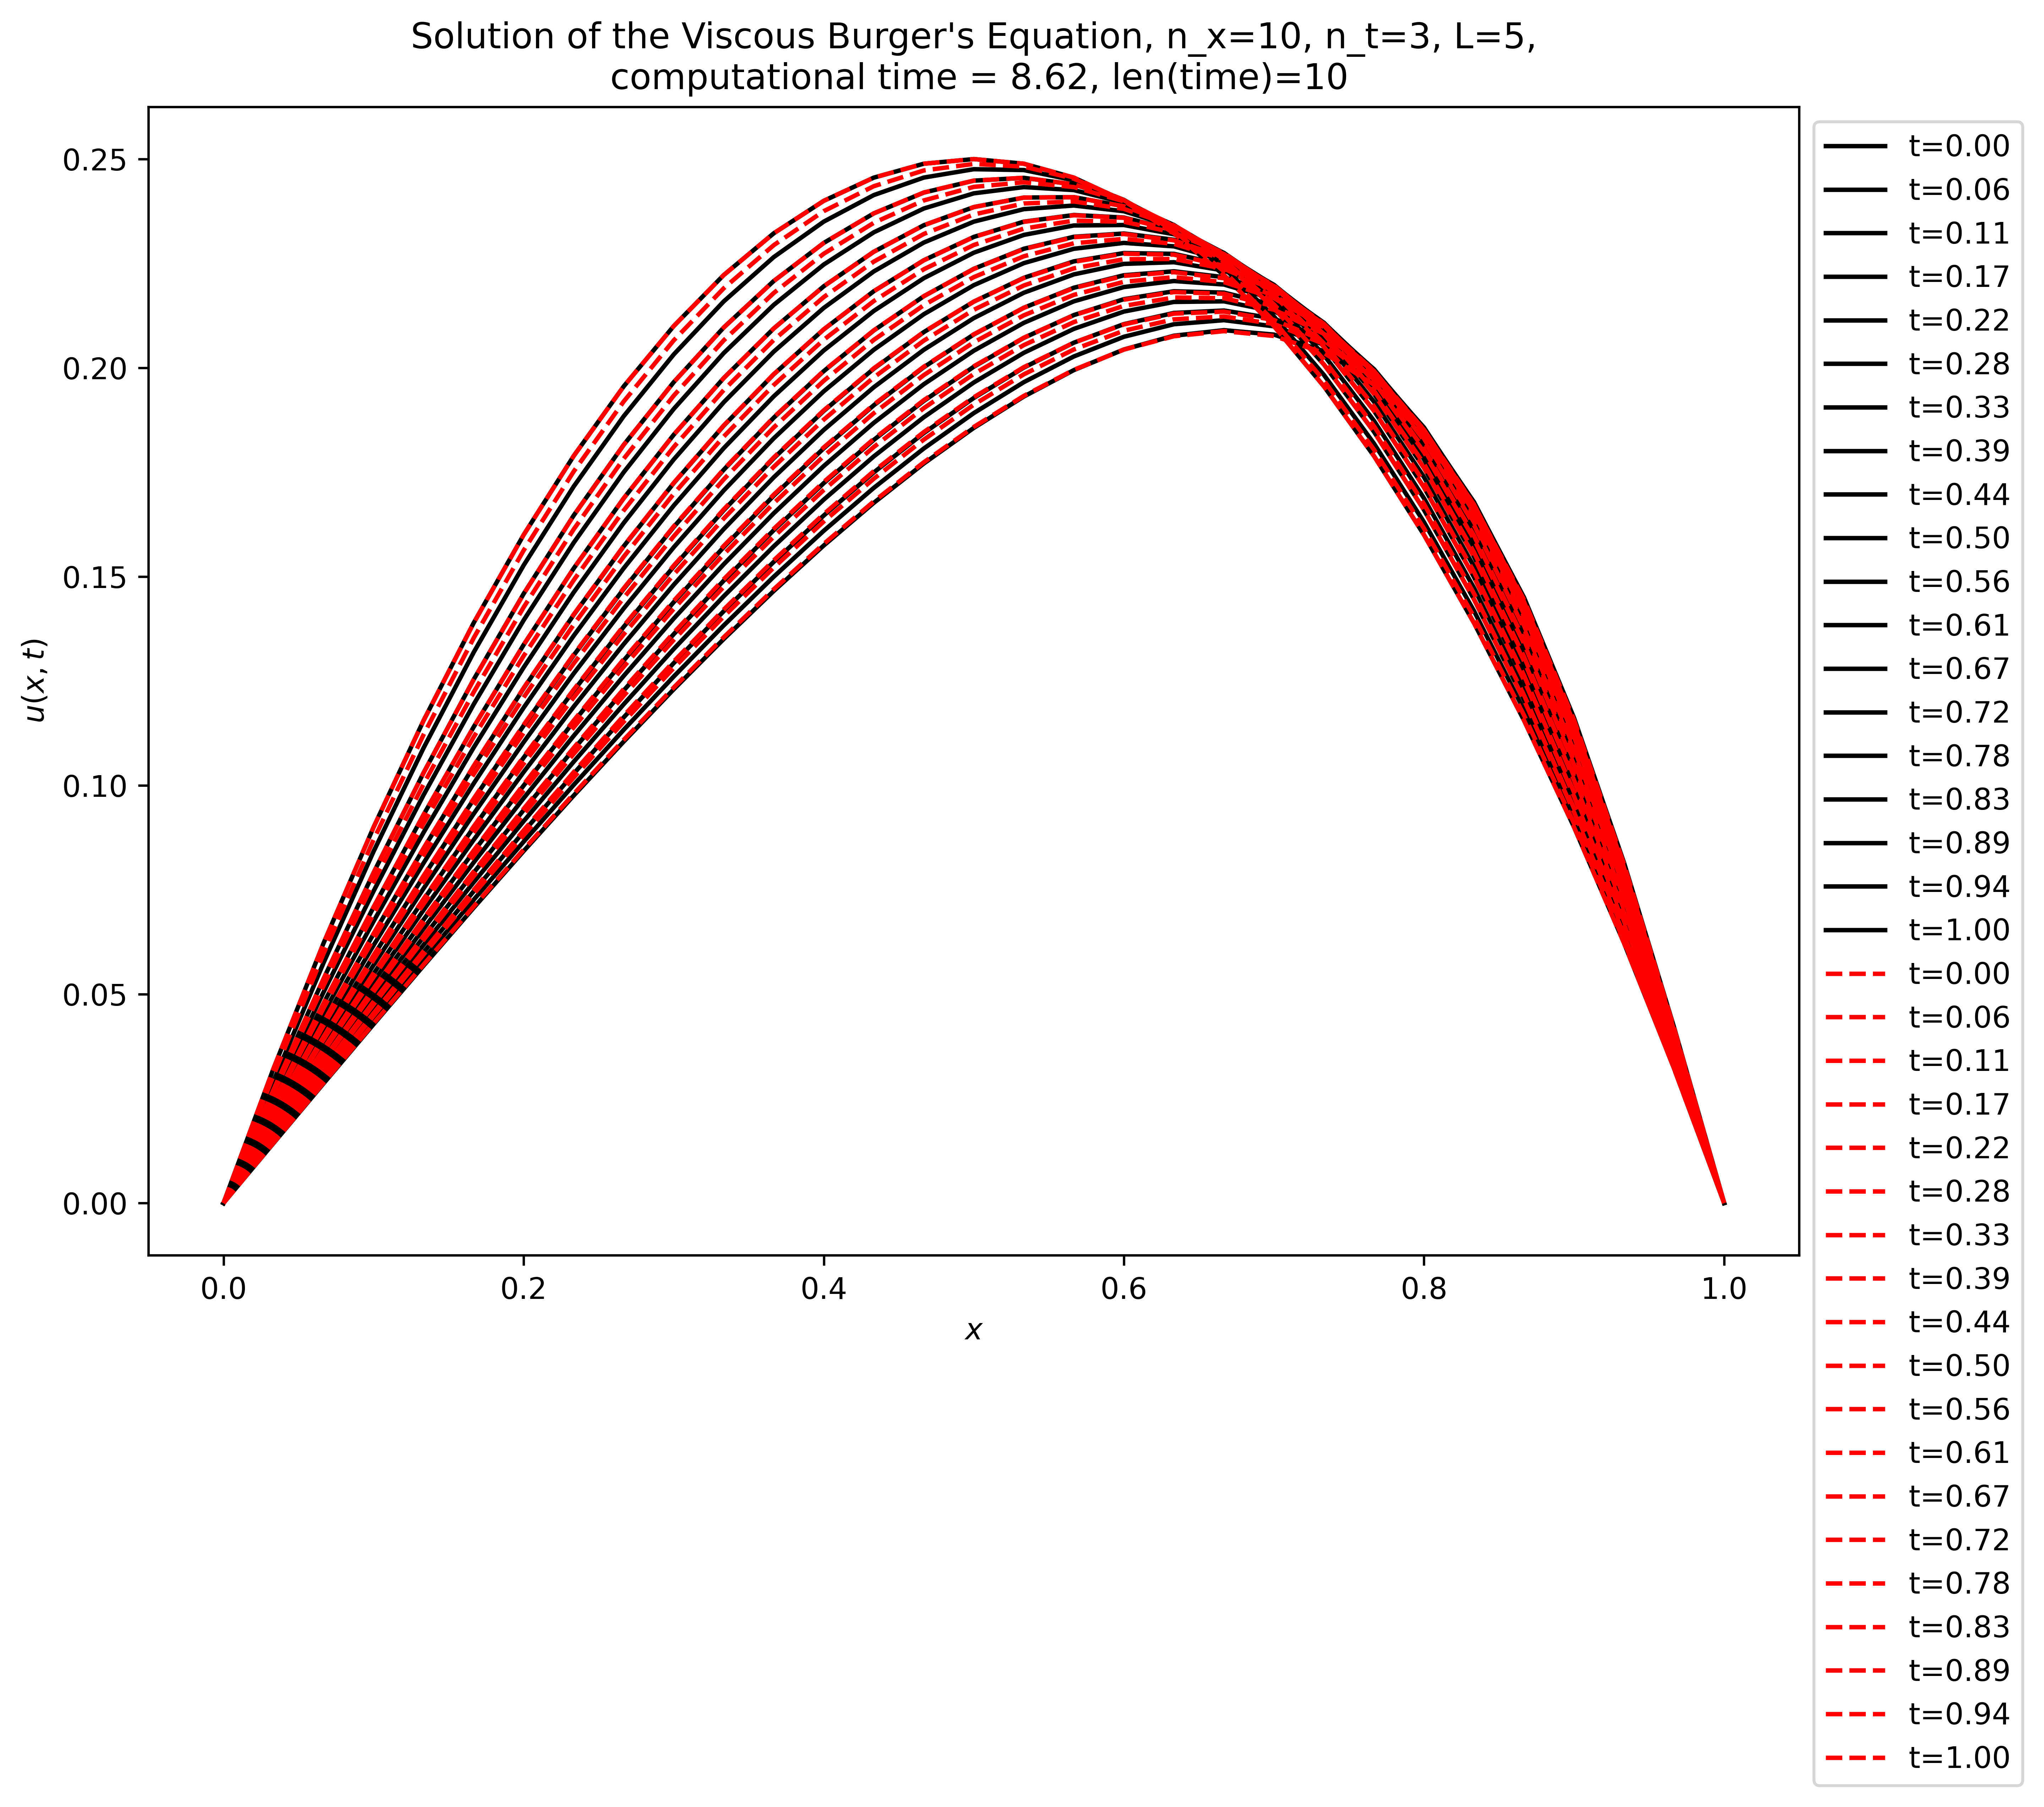

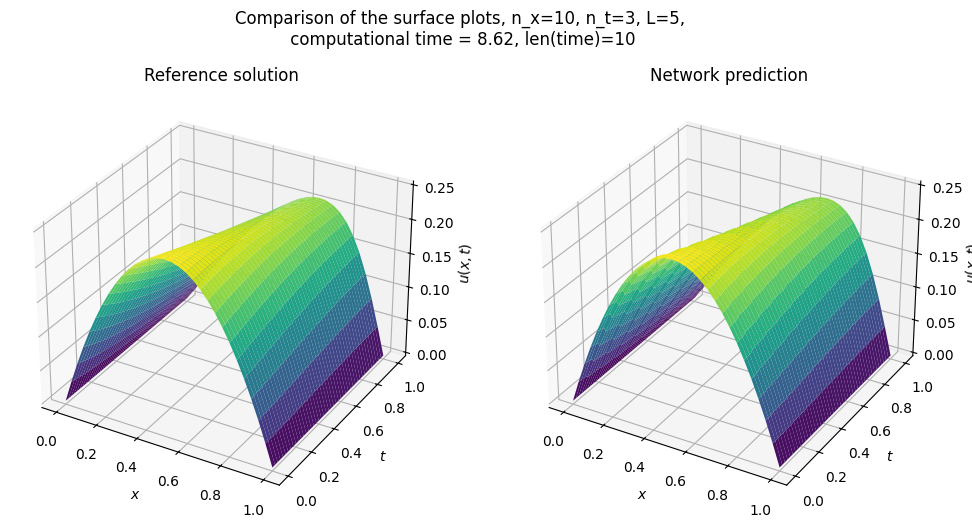

In [22]:
if len(y0)==2:
    list_of_labels = [r"$x$",r"$y$"]
elif len(y0)==3:
    list_of_labels = [r"$x$",r"$y$",r"$z$"]
elif len(y0)==4:
    list_of_labels = [r"$x$",r"$\dot{x}$",r"$y$",r"$\dot{y}$"]
else:
    list_of_labels = []
plot_results(y0,system,time_plot,time_plot_sequential,output,network_sol,list_of_labels,total_time,time,n_x,n_t,L,vecRef)

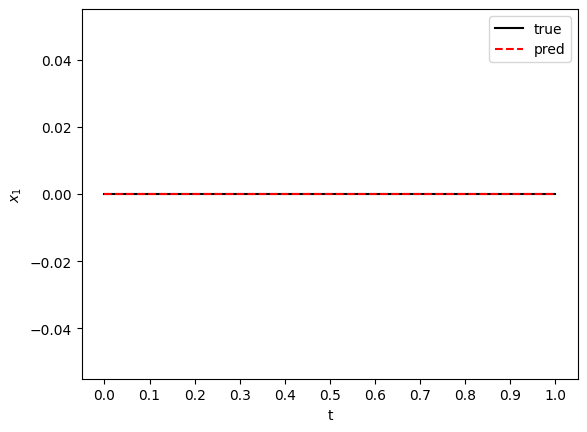

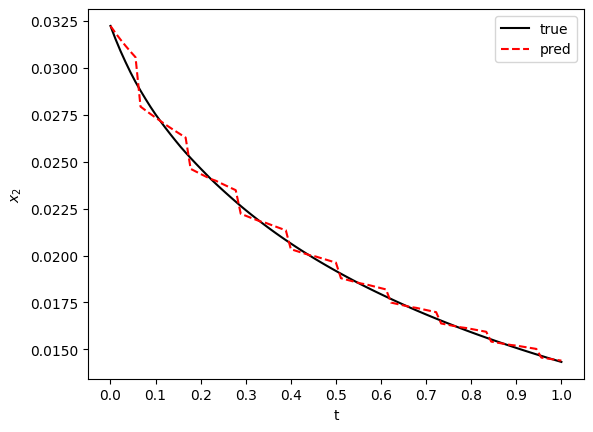

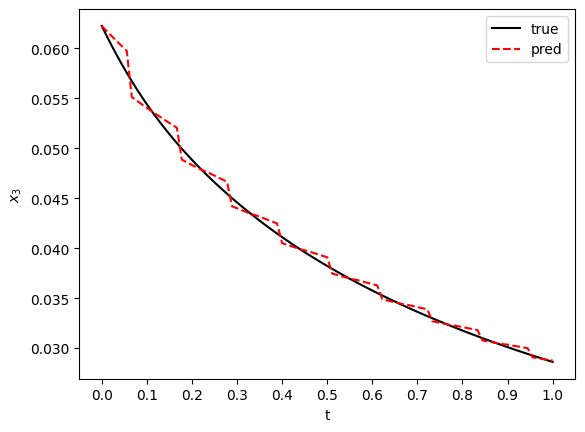

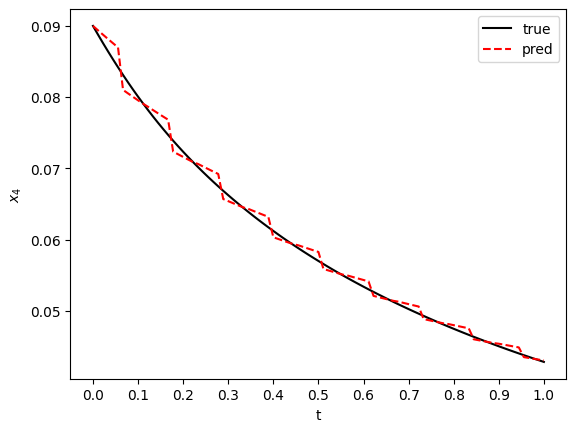

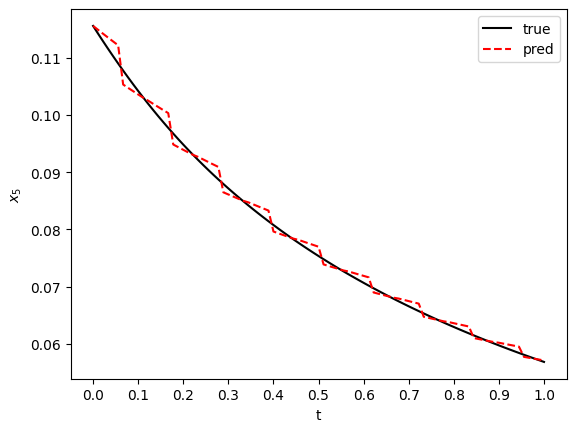

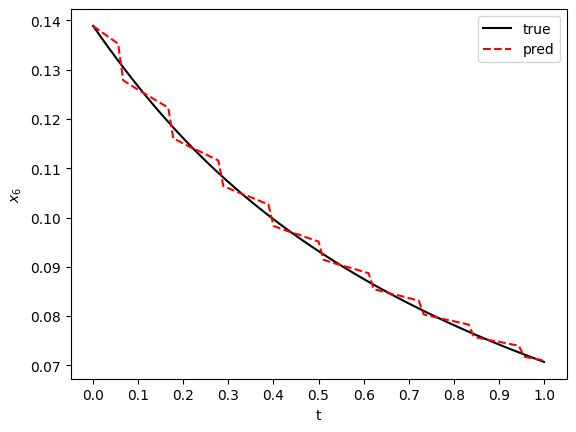

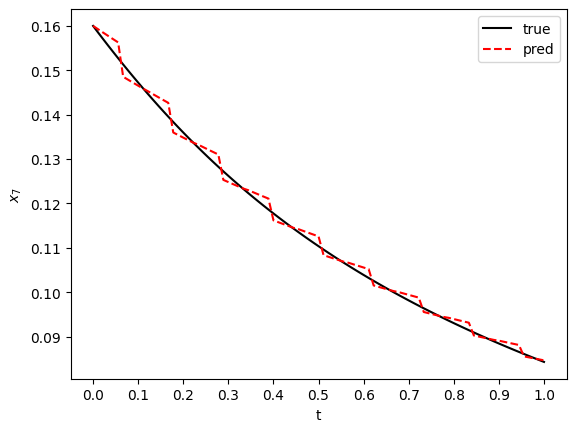

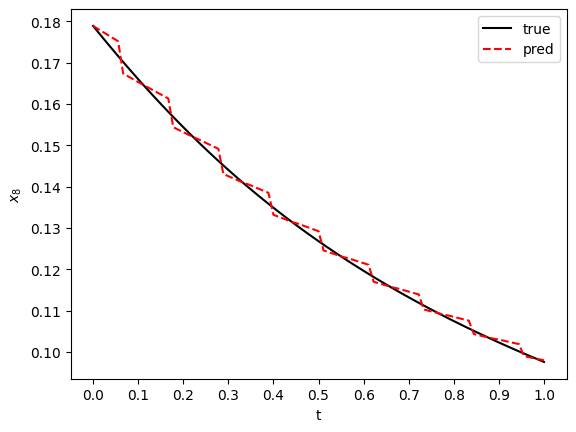

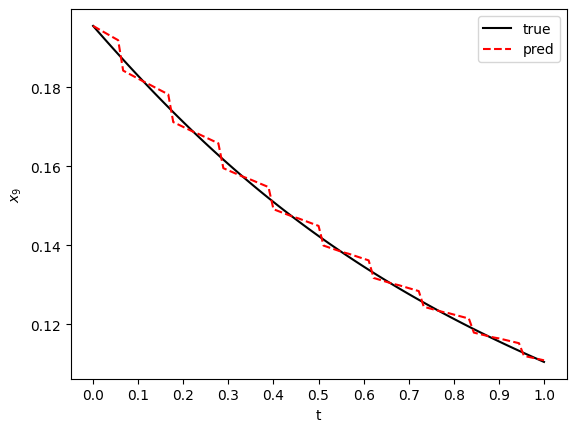

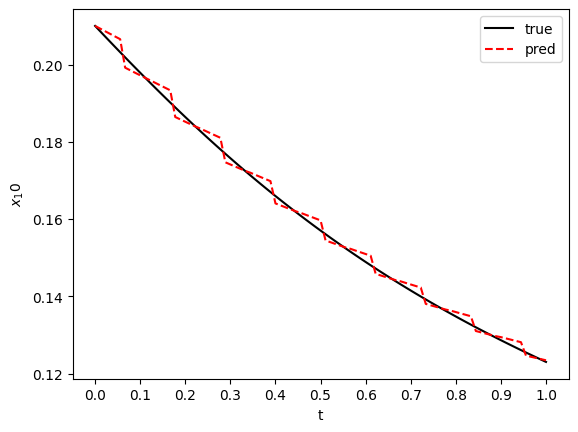

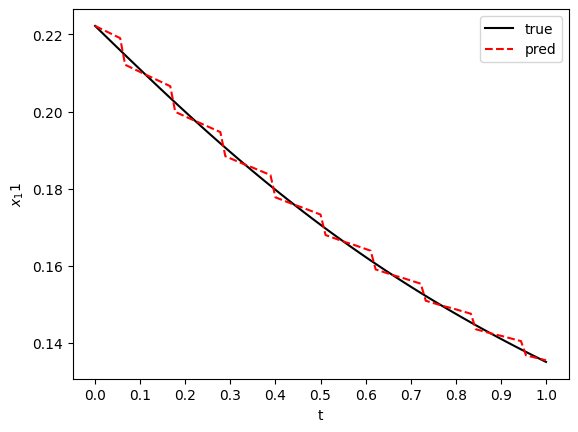

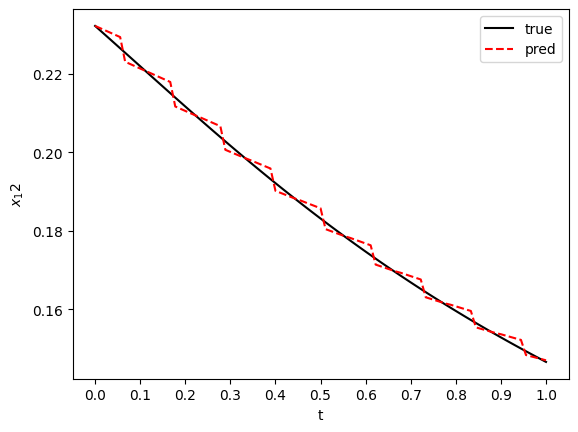

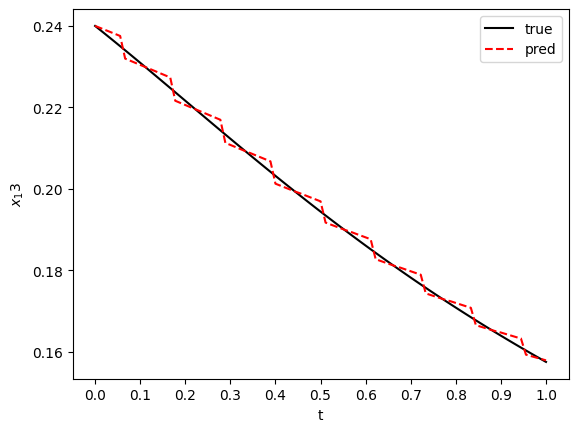

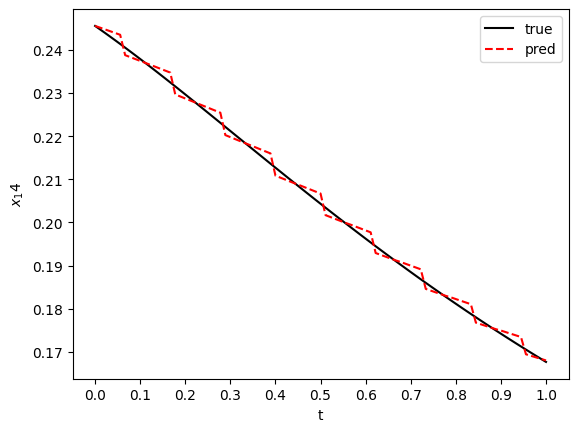

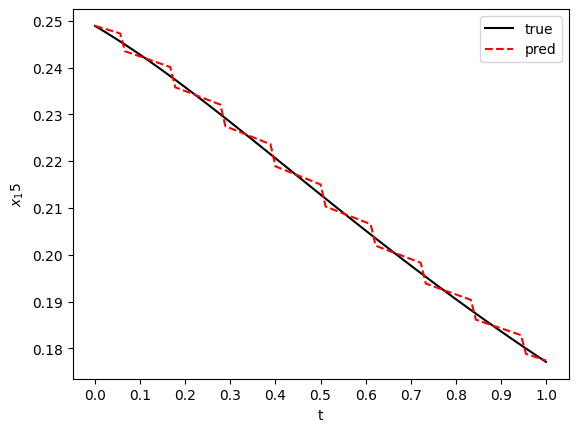

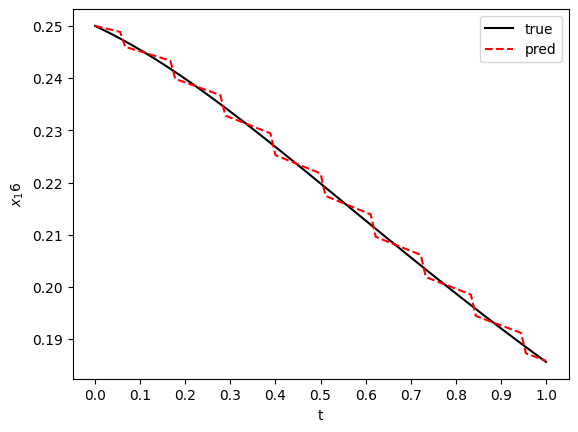

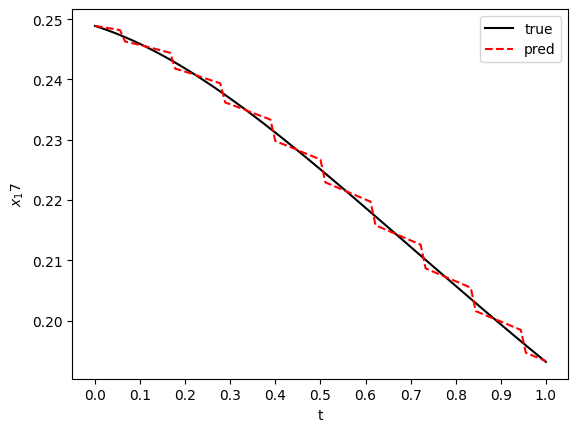

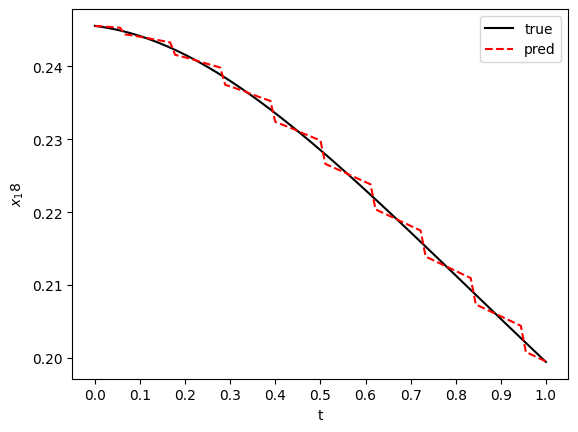

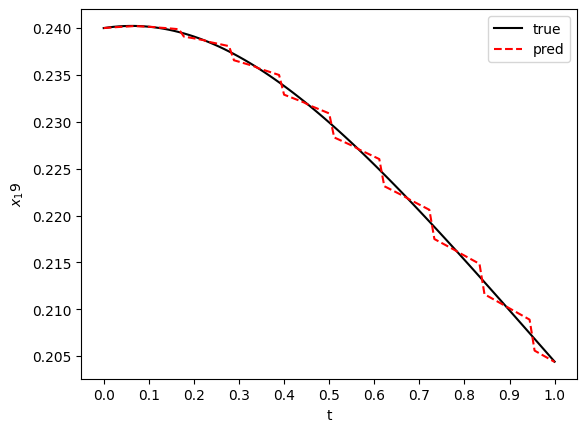

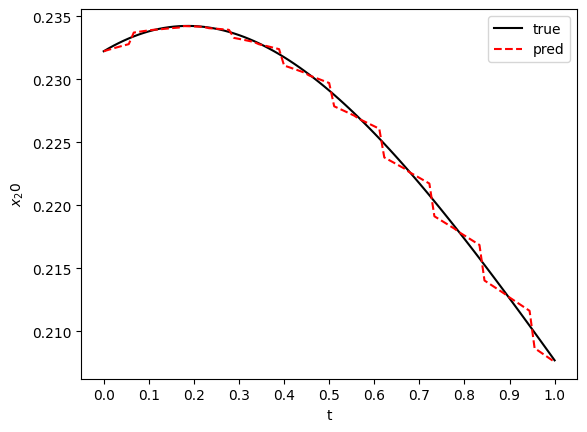

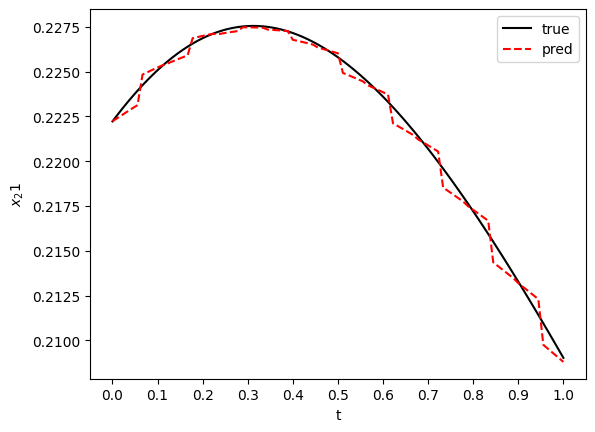

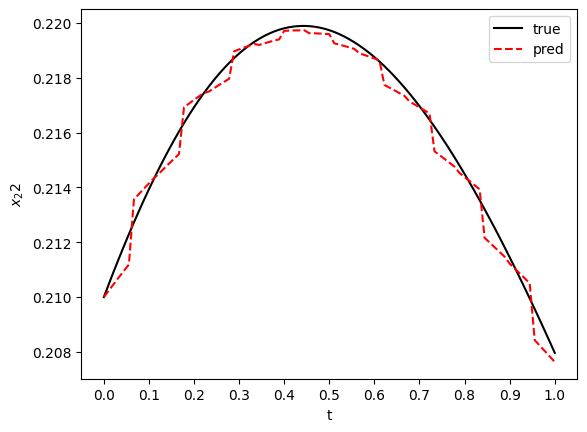

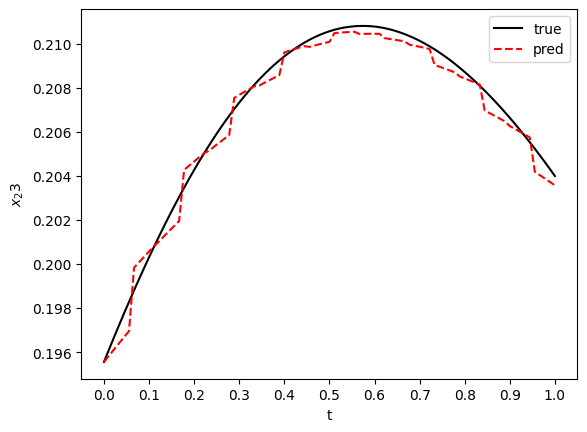

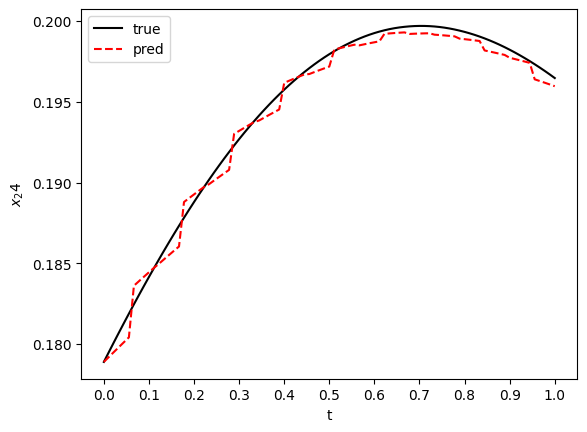

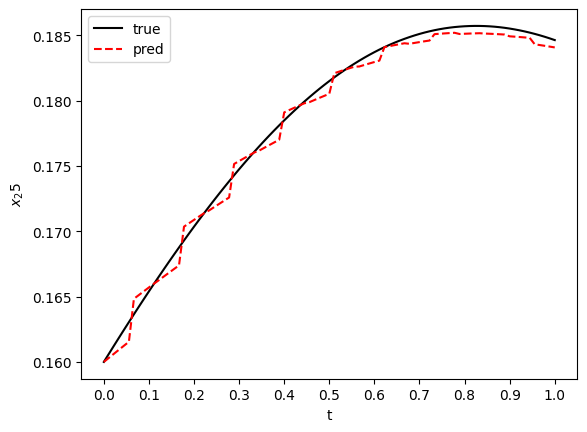

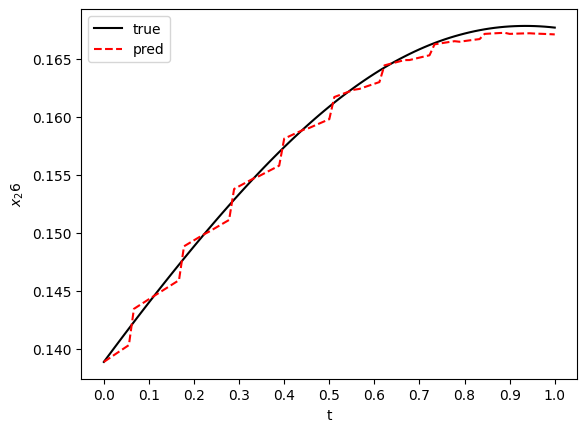

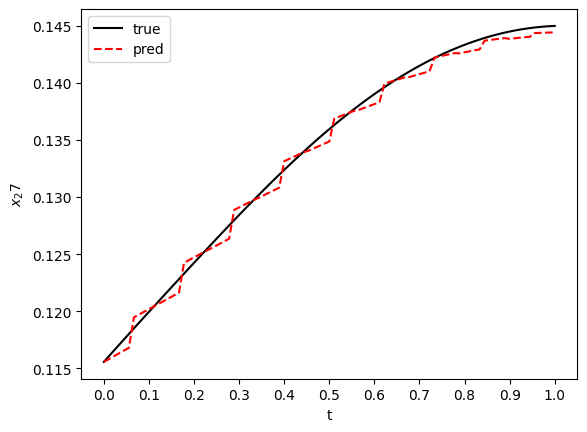

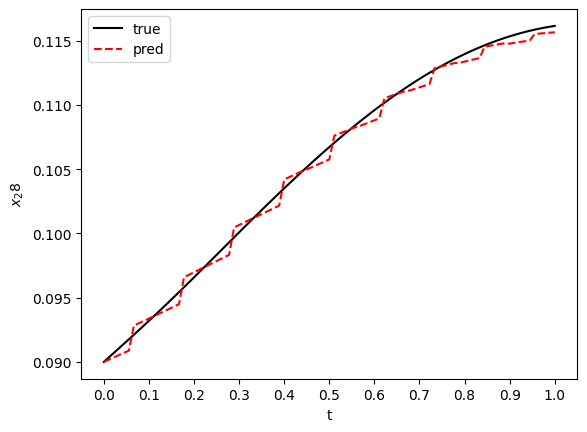

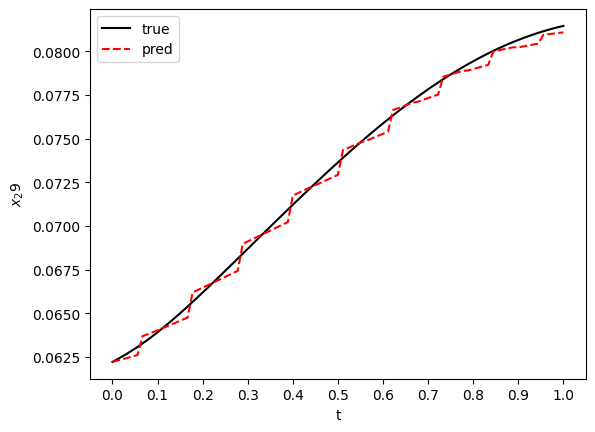

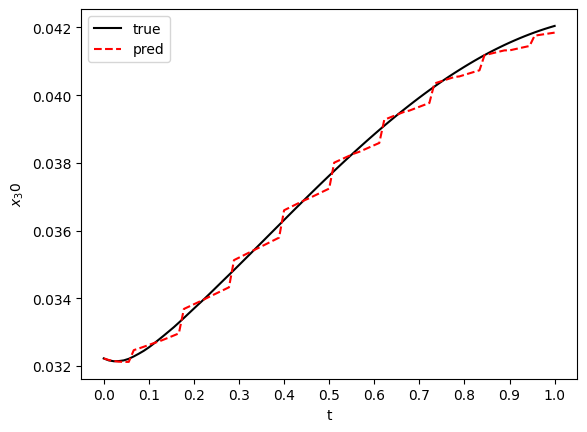

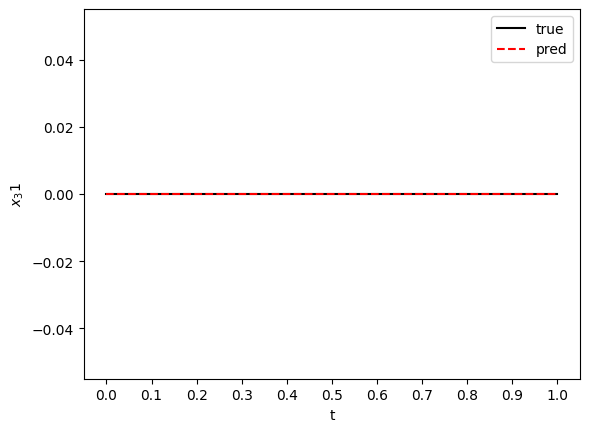

In [23]:
vec = vecRef

for i in range(vec.N):
    fig = plt.figure()
    plt.plot(time_plot, output[:,i],'k-',label='true')
    plt.plot(time_plot, network_sol[i],'r--',label='pred')
    plt.xlabel("t")
    plt.ylabel(fr"$x_{i+1}$")
    plt.xticks(np.linspace(0,1,11))
    plt.legend()
    plt.show();